In [1]:
import tensorflow as tf
import os
import numpy as np
from keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [2]:
train_data_directory = filepath=Path('./Covid19-dataset/train')
test_data_directory = filepath=Path('./Covid19-dataset/test')

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_dataset = train_datagen.flow_from_directory(train_data_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

validation_dataset = test_datagen.flow_from_directory(test_data_directory,
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [23]:
training_dataset.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [5]:
from keras.applications import densenet, VGG16

In [24]:
base_model1 = densenet.DenseNet121(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
model1 = tf.keras.Model(base_model1.input, tf.keras.layers.GlobalAveragePooling2D()(base_model1.output))

In [25]:
base_model2 = VGG16(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
model2 = tf.keras.Model(base_model2.input, tf.keras.layers.GlobalAveragePooling2D()(base_model2.output))

In [8]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [26]:
from PIL import Image
print('calculating training set')
train1 = model1.predict(training_dataset, len(training_dataset))
print('calculating test set')
test1 = model1.predict(validation_dataset, len(validation_dataset))

calculating training set
32/32 [==============================] - 27s 765ms/step
calculating test set
9/9 [==============================] - 6s 589ms/step


In [27]:
from PIL import Image
print('calculating training set')
train2 = model2.predict(training_dataset, len(training_dataset))
print('calculating test set')
test2 = model2.predict(validation_dataset, len(validation_dataset))

calculating training set
32/32 [==============================] - 38s 1s/step
calculating test set
9/9 [==============================] - 11s 1s/step


In [29]:
train = np.concatenate((train1,train2),axis=1)
test = np.concatenate((test1,test2),axis=1)

In [11]:
train.shape

(251, 1536)

In [49]:
# Relief F
from ReliefF import ReliefF
from sklearn.svm import SVC
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train, test, training_dataset.classes, validation_dataset.classes
f1_score_list = []
for k in range(1,1536):
    fs = ReliefF(n_neighbors=2, n_features_to_keep=k)
    X_train_new = fs.fit_transform(X_train, y_train)
    X_test_new = fs.fit_transform(X_test, y_test)
    
    dt = SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train_new, y_train)

    dt.fit(X_train_new, y_train)
    kbest_preds = dt.predict(X_test_new)
    f1_score_kbest = round(f1_score(y_test, kbest_preds, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)
    

In [51]:
# Chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train, test, training_dataset.classes, validation_dataset.classes
f1_score_list = []
for k in range(1, 1536):
    selector = SelectKBest(chi2, k=k)
    selector.fit(X_train, y_train)
    
    sel_X_train_v2 = selector.transform(X_train)
    sel_X_test_v2 = selector.transform(X_test)
    

    dt = DecisionTreeClassifier(random_state=42)
    # dt = SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(sel_X_train_v2, y_train)

    kbest_preds = dt.predict(sel_X_test_v2)
    f1_score_kbest = round(f1_score(y_test, kbest_preds, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)
  
# print(f1_score_list)

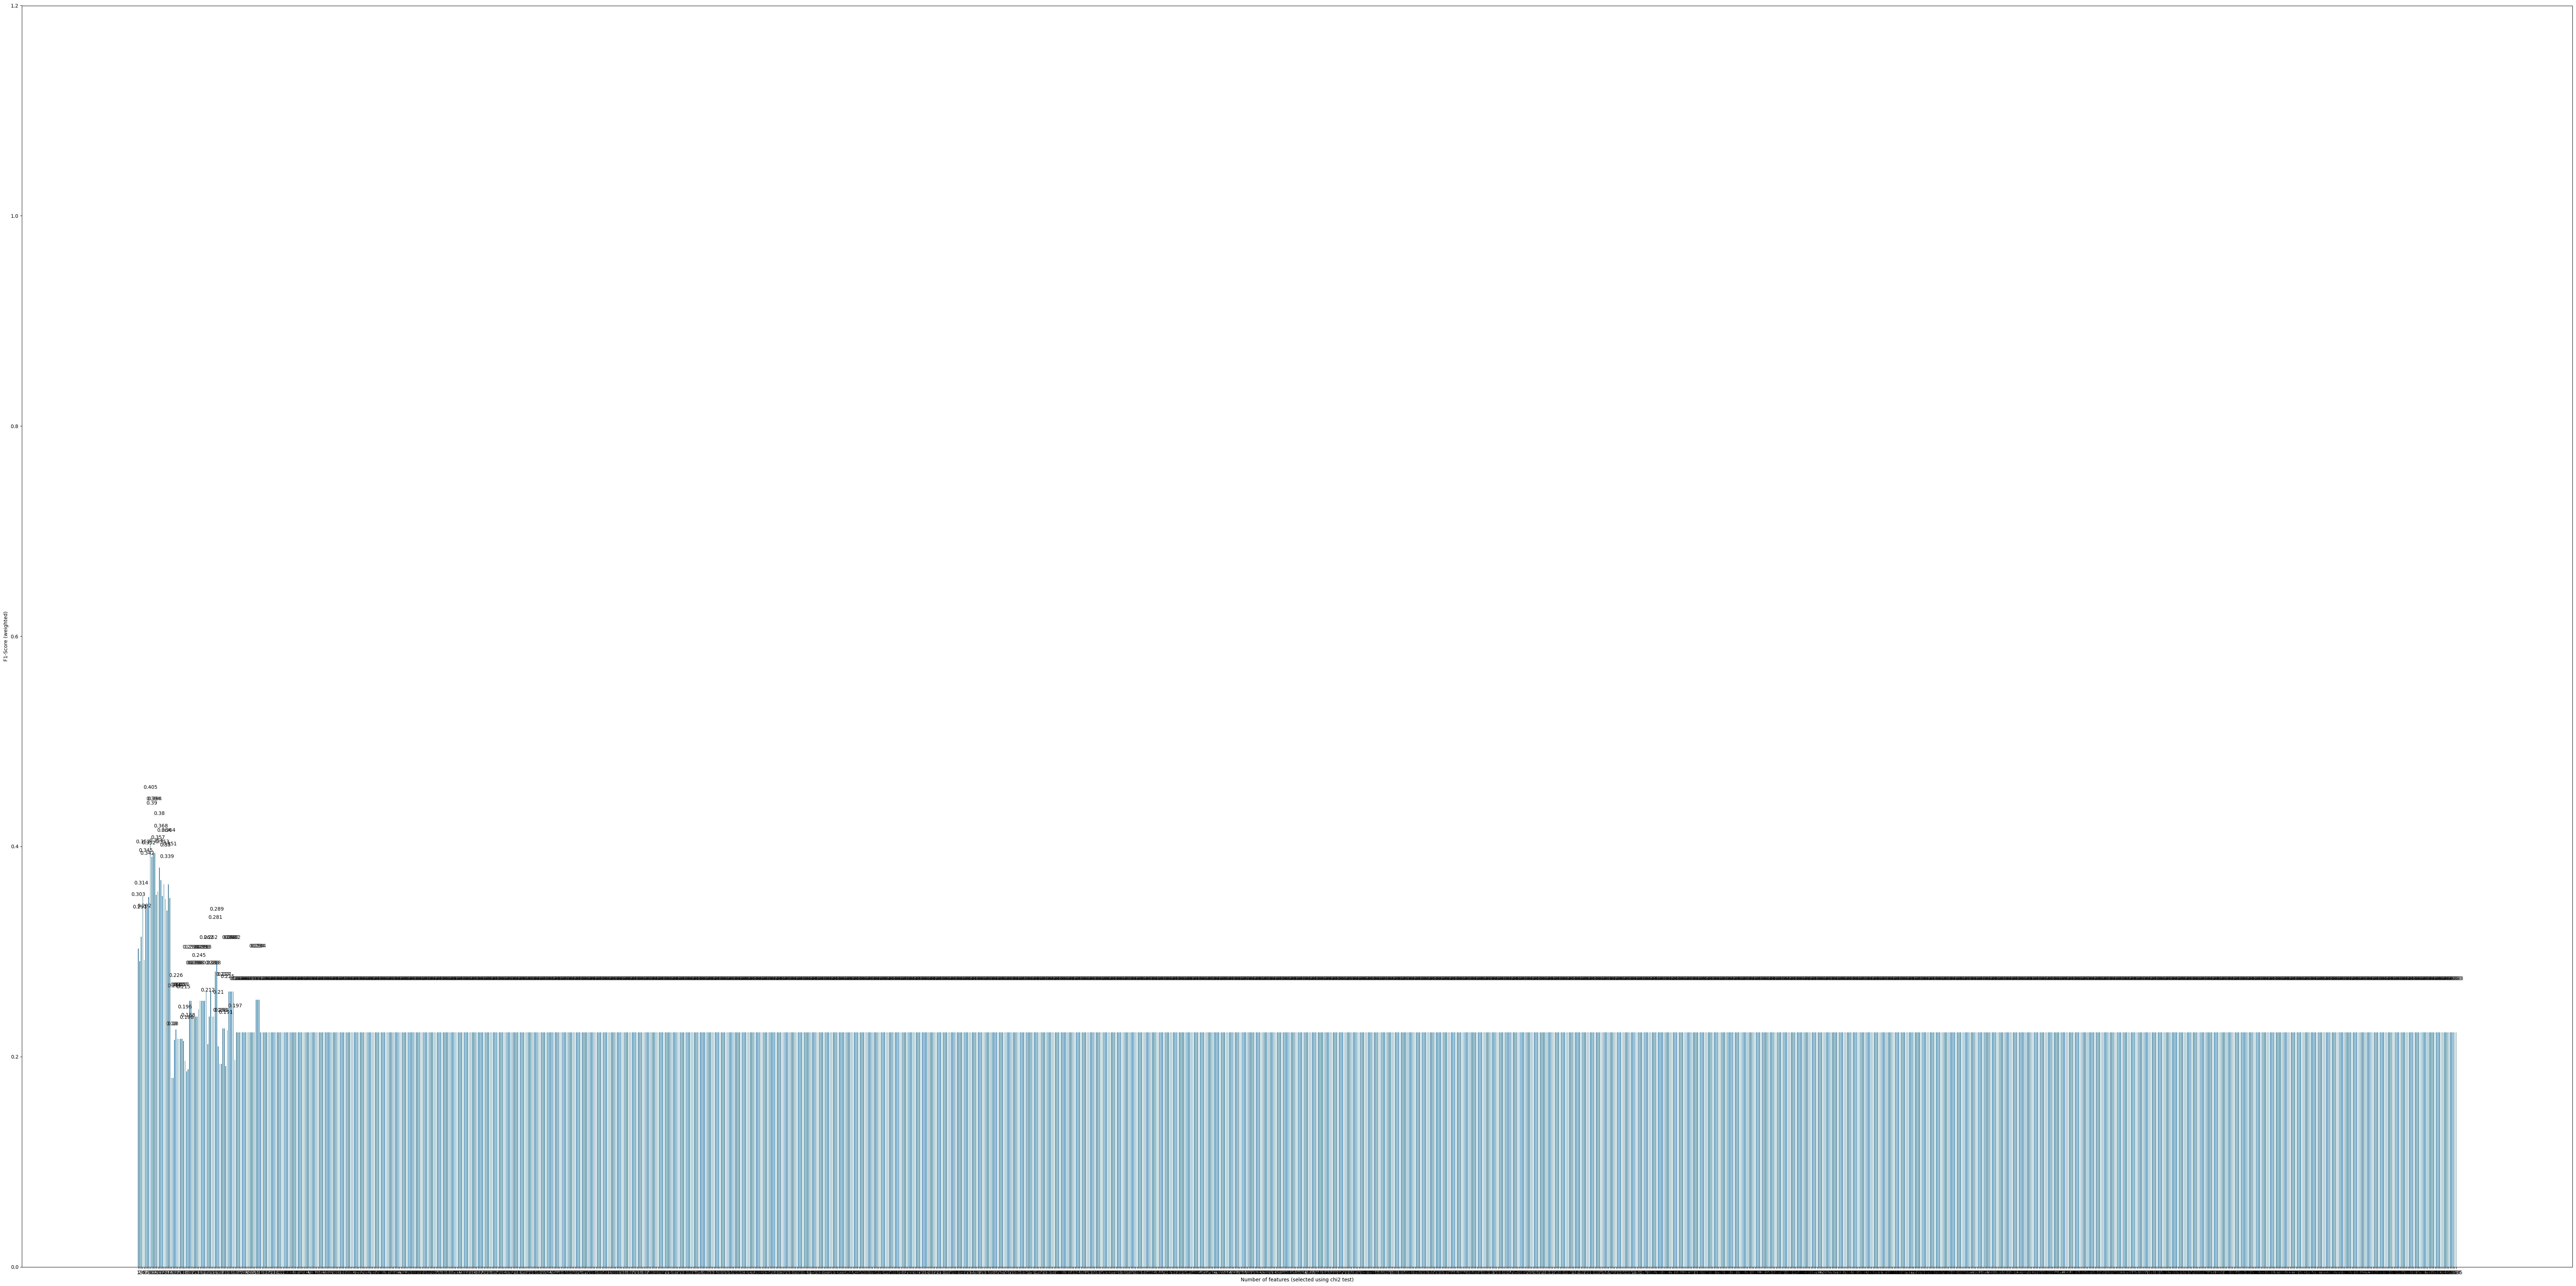

In [52]:
fig, ax = plt.subplots(figsize=(72, 36))
x = []
for i in range(1,1536):
    x.append(str(i))
y = f1_score_list
ax.bar(x, y, width=0.4)
ax.set_xlabel('Number of features (selected using chi2 test)')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()